In [2]:
!nvidia-smi

Sun Jul 11 18:57:39 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    22W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
%pip install -q --extra-index-url https://developer.download.nvidia.com/compute/redist --upgrade nvidia-dali-cuda110
%pip install -q wandb

     |████████████████████████████████| 621.4MB 27kB/s 
     |████████████████████████████████| 1.8MB 13.7MB/s 
     |████████████████████████████████| 143kB 66.5MB/s 
     |████████████████████████████████| 174kB 57.9MB/s 
     |████████████████████████████████| 102kB 14.1MB/s 
     |████████████████████████████████| 71kB 10.3MB/s 


In [4]:
# from google.colab import files
# ret = files.upload()
!mkdir  ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d xhlulu/flickrfaceshq-dataset-nvidia-resized-256px
# !kaggle datasets download -d jessicali9530/celeba-dataset

100% 1.88G/1.89G [00:30<00:00, 75.6MB/s]
100% 1.89G/1.89G [00:30<00:00, 66.3MB/s]


In [5]:
!unzip -q flickrfaceshq-dataset-nvidia-resized-256px.zip
!rm flickrfaceshq-dataset-nvidia-resized-256px.zip
# !unzip -q celeba-dataset.zip
# !rm celeba-dataset.zip

In [6]:
!mkdir flickrface_dataset
!mv resized flickrface_dataset/

In [ ]:
DATA_DIR = "/content/flickrface_dataset/"

# Import Libraries

In [1]:
%load_ext tensorboard
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import autograd
from torch.cuda import amp

import os
import random
import numpy as np
from tqdm import tqdm
import PIL.Image as Image
from collections import OrderedDict
import matplotlib.pyplot as plt
plt.rcParams['figure.facecolor'] = 'white'

In [3]:
import wandb

In [4]:
config_defaults = {
    'BATCH_SIZE'        : 128,
    'noise_dim'         : 128,
    'input_size'        : 256,
    'dp_rate'           : 0.3,
    'gauss_std'         : 0.1,
    'std_decay_rate'    : 0.,#1/100,  # DO VERIFY
    'guassian_noise'    : ['discriminator'],
    'nthreads'          : 2 * len(os.sched_getaffinity(0)),
    'max_lr'            : 2e-4,
    'betas'             : (0.5, 0.999),
    'seed'              : 614,
    'use_amp'           : True,
    'log_interval'      : 10,
    "z_notes"           : []
}
CONFIG = config_defaults

In [5]:
# #hide
# run = wandb.init(id='19sqz0by', project="facegan_pytorch", resume='must')
# CONFIG = run.config

In [6]:
run = wandb.init(project="facegan_pytorch", config=config_defaults)
CONFIG = wandb.config

wandb: Currently logged in as: shivamshrirao (use `wandb login --relogin` to force relogin)


In [7]:
def seed_everything(seed=33):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = True
    # torch.backends.cudnn.deterministic = True

seed_everything()

In [8]:
class AverageMeter:
    def __init__(self, name=None):
        self.name = name
        self.reset()

    def reset(self):
        self.val = self.sum = self.count = self.avg = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [9]:
from torchvision import transforms as T

from nvidia.dali.pipeline import Pipeline
import nvidia.dali.fn as fn
import nvidia.dali.types as types
from nvidia.dali.plugin.pytorch import DALIClassificationIterator, LastBatchPolicy

In [10]:
def get_preproc(input_size):
    return T.Compose([
        T.RandomResizedCrop(input_size, interpolation=T.InterpolationMode.BICUBIC),
        T.RandomHorizontalFlip(input_size),
        lambda image: image.convert("RGB"),
        T.ToTensor(),
        T.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
    ])


def dali_pipeline(batch_size, num_threads, device_id, image_dir, input_size):
    pipe = Pipeline(batch_size, num_threads, device_id)
    with pipe:
        jpegs, lbls = fn.readers.file(file_root=image_dir, random_shuffle=True, name="Reader")
        images = fn.decoders.image(jpegs, device='mixed', output_type=types.RGB)
        images = fn.resize(images, device='gpu', resize_shorter=input_size, interp_type=types.INTERP_TRIANGULAR)
        mirror = fn.random.coin_flip(probability=0.5)
        images = fn.crop_mirror_normalize(images,
                                          dtype=types.FLOAT,
                                          output_layout="CHW",
                                          crop=(input_size, input_size),
                                          mean=[0.5 * 255, 0.5 * 255, 0.5 * 255],
                                          std=[0.5 * 255, 0.5 * 255, 0.5 * 255],
                                          mirror=mirror)
        pipe.set_outputs(images, lbls)
    return pipe

In [11]:
CONFIG['nthreads']

8

In [12]:
pipe = dali_pipeline(batch_size=CONFIG['BATCH_SIZE'], num_threads=CONFIG["nthreads"], device_id=0, image_dir=DATA_DIR, input_size=CONFIG["input_size"])
train_loader = DALIClassificationIterator(pipe, auto_reset=True, reader_name="Reader", last_batch_policy=LastBatchPolicy.PARTIAL)

In [13]:
class GaussianNoise(nn.Module):                         # Try noise just for real or just for fake images.
    def __init__(self, std=0.1, decay_rate=0):
        super().__init__()
        self.std = std
        self.decay_rate = decay_rate

    def decay_step(self):
        self.std = max(self.std - self.decay_rate, 0)

    def forward(self, x):
        if self.training:
            return x + torch.empty_like(x).normal_(std=self.std)
        else:
            return x

In [14]:
class Generator(nn.Module):
    def __init__(self, noise_dim, activation=nn.LeakyReLU, dp_rate=0.3):
        super().__init__()
        self.activation = activation
        self.stem = nn.Sequential(OrderedDict([
            ('linear',  nn.Linear(noise_dim, 1024*4*4, bias=False)),            # remove this, replace with just conv
            ('bn',      nn.LazyBatchNorm1d()),
            ('act',     activation(0.2, inplace=True)),
            ('dropout', nn.Dropout(dp_rate)),       # try 2d for spatial
        ]))

        self.stacks = nn.Sequential(*[
            self.upsample(512, dp_rate=dp_rate),
            self.upsample(256, dp_rate=dp_rate),
            self.upsample(128, dp_rate=dp_rate),
            self.upsample( 64, dp_rate=dp_rate),
            self.upsample( 32, dp_rate=0)           # add one more with stride 1
        ])

        self.gen = nn.Sequential(OrderedDict([
            ('conv',    nn.LazyConvTranspose2d(3, kernel_size=4, stride=2, padding=1)),
            ('act',     nn.Tanh()),
        ]))

    def upsample(self, num_filters, bn=True, dp_rate=0.3):
        layers = [nn.LazyConvTranspose2d(num_filters, kernel_size=4, stride=2, bias=not bn, padding=1)]
        if bn:
            layers.append(nn.BatchNorm2d(num_filters))
        layers.append(self.activation(0.2, inplace=True))
        if dp_rate > 0:
            layers.append(nn.Dropout2d(dp_rate))      # try 2d for spatial
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.stem(x)
        x = x.view(-1, 1024, 4, 4)
        x = self.stacks(x)
        x = self.gen(x)
        return x

In [15]:
class Discriminator(nn.Module):
    def __init__(self, activation=nn.LeakyReLU, std=0.1, std_decay_rate=0):
        super().__init__()
        self.std = std
        self.std_decay_rate = std_decay_rate
        self.activation = activation
        self.stacks = nn.Sequential(*[
            self.downsample(32, bn=False),
            self.downsample(64),
            self.downsample(128),
            self.downsample(256),
            self.downsample(512),
            self.downsample(1024),
        ])

        self.head = nn.Sequential(OrderedDict([
            ('gauss', GaussianNoise(self.std, self.std_decay_rate)),
            ('linear', nn.LazyLinear(1)),
            # ('act', nn.Sigmoid()),        # removed for BCEWithLogitsLoss
        ]))

    def downsample(self, num_filters, bn=True, stride=2):
        layers = [
            GaussianNoise(self.std, self.std_decay_rate),
            nn.LazyConv2d(num_filters, kernel_size=4, stride=stride, bias=not bn, padding=1)
        ]
        if bn:
            layers.append(nn.BatchNorm2d(num_filters))
        layers.append(self.activation(0.2, inplace=True))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.stacks(x)
        x = x.flatten(1)
        x = self.head(x)
        return x

In [16]:
@torch.no_grad()
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [17]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [18]:
netG = Generator(CONFIG['noise_dim'], dp_rate=CONFIG['dp_rate']).to(DEVICE)
netD = Discriminator(std=CONFIG['gauss_std'], std_decay_rate=CONFIG['std_decay_rate']).to(DEVICE)

netG.apply(weights_init)
netD.apply(weights_init)

criterion = nn.BCEWithLogitsLoss()

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [19]:
from torchsummary import summary

In [20]:
summary(netG, (CONFIG['noise_dim'],))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 16384]       2,097,152
       BatchNorm1d-2                [-1, 16384]          32,768
              ReLU-3                [-1, 16384]               0
           Dropout-4                [-1, 16384]               0
   ConvTranspose2d-5            [-1, 512, 8, 8]       8,388,608
       BatchNorm2d-6            [-1, 512, 8, 8]           1,024
              ReLU-7            [-1, 512, 8, 8]               0
         Dropout2d-8            [-1, 512, 8, 8]               0
   ConvTranspose2d-9          [-1, 256, 16, 16]       2,097,152
      BatchNorm2d-10          [-1, 256, 16, 16]             512
             ReLU-11          [-1, 256, 16, 16]               0
        Dropout2d-12          [-1, 256, 16, 16]               0
  ConvTranspose2d-13          [-1, 128, 32, 32]         524,288
      BatchNorm2d-14          [-1, 128,

In [21]:
summary(netD, (3, CONFIG['input_size'], CONFIG['input_size']))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
     GaussianNoise-1          [-1, 3, 256, 256]               0
            Conv2d-2         [-1, 32, 128, 128]           1,568
         LeakyReLU-3         [-1, 32, 128, 128]               0
     GaussianNoise-4         [-1, 32, 128, 128]               0
            Conv2d-5           [-1, 64, 64, 64]          32,768
       BatchNorm2d-6           [-1, 64, 64, 64]             128
         LeakyReLU-7           [-1, 64, 64, 64]               0
     GaussianNoise-8           [-1, 64, 64, 64]               0
            Conv2d-9          [-1, 128, 32, 32]         131,072
      BatchNorm2d-10          [-1, 128, 32, 32]             256
        LeakyReLU-11          [-1, 128, 32, 32]               0
    GaussianNoise-12          [-1, 128, 32, 32]               0
           Conv2d-13          [-1, 256, 16, 16]         524,288
      BatchNorm2d-14          [-1, 256,

In [22]:
wandb.watch([netG, netD], log=None)

In [23]:
optG = torch.optim.Adam(netG.parameters(), lr=CONFIG['max_lr'], betas=CONFIG['betas'])
optD = torch.optim.Adam(netD.parameters(), lr=CONFIG['max_lr'], betas=CONFIG['betas'])

scaler = amp.GradScaler(enabled=CONFIG['use_amp'])

In [24]:
def set_grads(grads, params):
    for g,p in zip(grads, params):
        p.grad = g

def train_epoch(train_loader, netG, netD, optG, optD, scaler, noise_dim, epoch=1, use_amp=True, log_interval=10):
    netG.train()
    netD.train()
    lossesG = AverageMeter()
    lossesD = AverageMeter()
    optG.zero_grad(set_to_none=True)
    optD.zero_grad(set_to_none=True)
    with tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch:>2}") as pbar:
        for idx, batch in pbar:
            real_images = batch[0]['data']
            noise = torch.randn(real_images.size(0), noise_dim, dtype=real_images.dtype,
                                device=real_images.device)
            with amp.autocast(enabled=use_amp):
                fake_out = netD(netG(noise))
                real_out = netD(real_images)
                lossG = criterion(fake_out, torch.ones_like(fake_out))                          # Treat fake images as real to train the Generator.
                lossD = (criterion(real_out, torch.empty_like(real_out).uniform_(0.9, 1.0))     # Treat real as real
                        + criterion(fake_out, torch.empty_like(fake_out).uniform_(0.0, 0.1)))   # and fake as fake to train Discriminator.

            scaled_gradsG = autograd.grad(scaler.scale(lossG), netG.parameters(), retain_graph=True)
            scaled_gradsD = autograd.grad(scaler.scale(lossD), netD.parameters())

            set_grads(scaled_gradsG, netG.parameters())
            set_grads(scaled_gradsD, netD.parameters())

            scaler.step(optD)
            optD.zero_grad(set_to_none=True)
            scaler.step(optG)
            optG.zero_grad(set_to_none=True)
            scaler.update()

            lossesG.update(lossG.detach_(), noise.size(0))
            lossesD.update(lossD.detach_(), real_images.size(0))
            if not idx%log_interval:
                info = {'Generator_loss': float(lossesG.avg), 'Discriminator_loss': float(lossesD.avg)}
                wandb.log(info)
                pbar.set_postfix(info)

In [25]:
@torch.no_grad()
def gen_grid(ncols=4, nrows=4, figsize=[16,16], show=True, wb_log=True):
    netG.eval()
    noise = torch.randn(nrows*ncols, CONFIG['noise_dim'], dtype=torch.float32, device=DEVICE)
    gen = (netG(noise).detach_()+1)/2
    gen = gen.cpu().permute(0,2,3,1).numpy()       # convert to channel last
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, gridspec_kw = {'wspace':0, 'hspace':0})
    fig.patch.set_facecolor('black')
    ims = []
    for i,axi in enumerate(ax.flat):
        axi.axis("off")
        axi.imshow(gen[i])
        if wb_log: ims.append(wandb.Image(gen[i]))
    if wb_log: wandb.log({"Generated": ims})
    if show:
        plt.show()
    else:
        plt.close(fig)
    # return gen

In [26]:
def decay_gauss_std(net):
    std = 0
    for m in net.modules():
        if isinstance(m, GaussianNoise):
            m.decay_step()
            std = m.std
    wandb.log({'std': std})

In [27]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [28]:
init_epoch = 1
NUM_EPOCHS = 200

In [ ]:
# PLEASE CALCULATE FID/IS FIRST MAN

In [29]:
#collapse-output
for epoch in range(init_epoch, NUM_EPOCHS+1):
    train_loss = train_epoch(train_loader,
                             netG = netG,
                             netD = netD,
                             optG = optG,
                             optD = optD,
                             scaler = scaler,
                             noise_dim = CONFIG['noise_dim'],
                             epoch=epoch,
                             use_amp=CONFIG['use_amp'],
                             log_interval=CONFIG['log_interval'])
    
    gen_grid(ncols=4, nrows=2, figsize=[16, 8], show=False)
    gc.collect()
    decay_gauss_std(netD)
    # if not epoch%20:
    #     gen_grid(wb_log=False)
    #     save_model(model, optimizer, epoch)

Epoch 200: 100%|██████████| 547/547 [01:02<00:00,  8.72it/s, Generator_loss=3.04, Discriminator_loss=0.415]


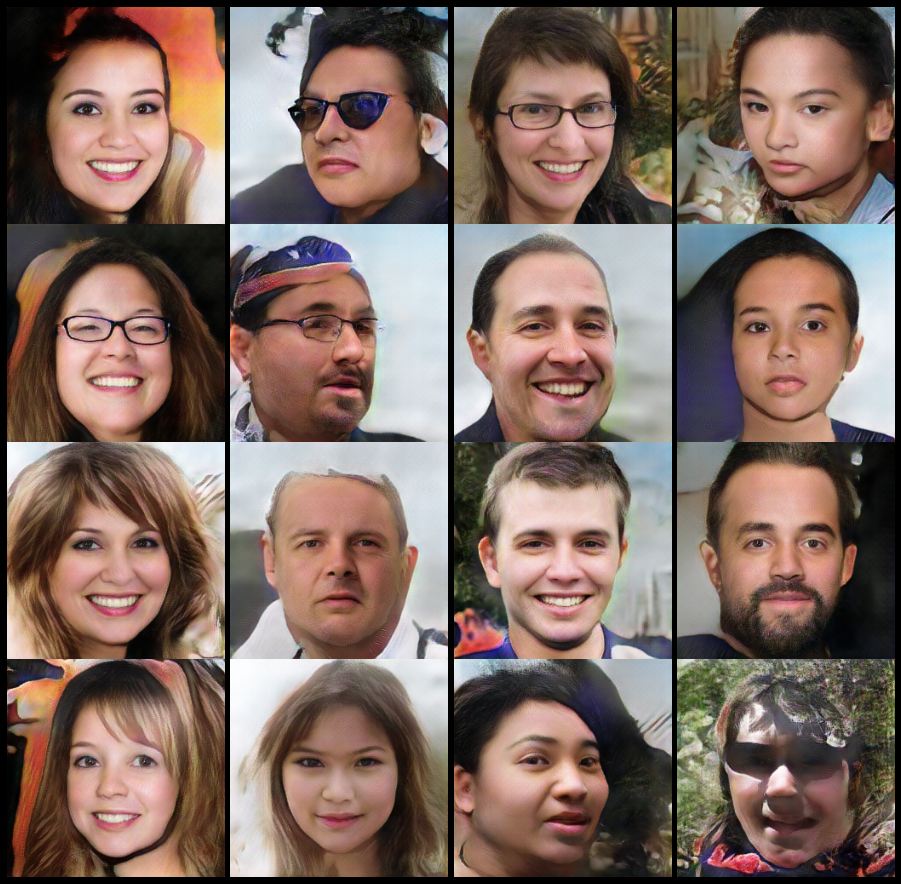

In [54]:
_ = gen_grid(wb_log=False)

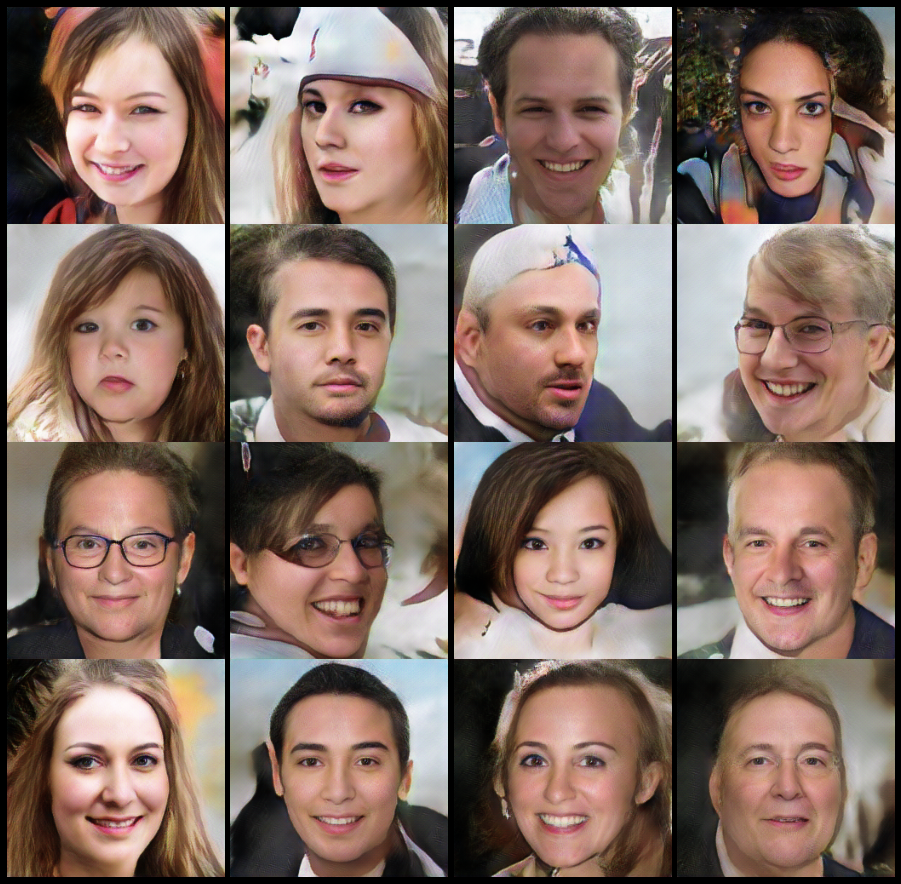

In [56]:
_ = gen_grid(wb_log=False)

In [31]:
run.finish()